In [1]:
import json
import pandas as pd
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pickle
import requests
from time import sleep
from random import randint
from langdetect import detect

sns.set(style="darkgrid")

Using TensorFlow backend.
/home/user/devel/projects/flaty/parser/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user/devel/projects/flaty/parser/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user/devel/projects/flaty/parser/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1

# Step 1. A rough filter

In [2]:
step_1 = 'step_1.json'
with open(step_1) as json_data:
    records = json.loads(json_data.read())
df = pd.DataFrame.from_records(records)
df = df.drop(columns=['living_country_id','pro_rating','language_strength',
                      'hour_per_week','finished_session_last_3_months','nickname'])
df['teacher_id'] = df['user_id']
df['country'] = df['origin_country_id']
df.drop(columns=['origin_country_id','user_id'], inplace=True)




In [3]:
df.head()

,about_me,about_teacher,finished_session,introduction,pro_course_detail,teaching_style,teacher_id,country
0,Hello everyone!\nMy name is Jeremy. I'm a nati...,I currently also work for a global language sc...,22,,"[{'teacher_id': 5754348, 'language': 'english'...",My main goal with students is to improve their...,5754348,CA
1,My name is Dave and I'm a CELTA and TEFL certi...,I have been teaching English as a foreign lang...,1198,,"[{'teacher_id': 3019343, 'language': 'english'...","Having reached the C2 level in Spanish, I have...",3019343,US
2,Hello!\nMy name is Ryan and I have been an ESL...,I have been teaching English for 3 years. In T...,137,,"[{'teacher_id': 6512293, 'language': 'english'...",You will notice that I put a lot of focus on p...,6512293,CA
3,I am a qualified language teacher. I hold an M...,"As a tutor, I try to stay open to new ideas an...",108,,"[{'teacher_id': 4089517, 'language': 'english'...",My classes are well structured and based on th...,4089517,AM
4,My name is Sarah and I'm from Cornwall in the ...,I have been teaching since 2013 when I went to...,97,,"[{'teacher_id': 6581705, 'language': 'english'...",I teach all levels. The lessons are designed f...,6581705,GB


In [4]:
df.describe()

,finished_session,teacher_id
count,1000.000000,1.000000e+03
mean,1253.193000,4.126967e+06
std,1825.903209,1.784199e+06
min,0.000000,1.297730e+05
25%,162.750000,2.882794e+06
50%,614.000000,4.347498e+06
75%,1672.500000,5.663898e+06
max,15921.000000,6.896142e+06


In [5]:
df['price_1h'] = 0.0
df['package'] = 0.0
hour_session_id = 4
for i, row in df.iterrows():
    classes = row.pro_course_detail
    if not classes:
        continue
    for _class in classes:
        title = _class['title']
        if 'FCE' in title or 'CAE' in title or 'Cambridge' in title \
                or 'Exam' in title:
            prices_list = _class['price_list']
            for price in prices_list:
                if price['session_length'] == hour_session_id:
                    df.at[i, 'price_1h'] = price['session_price']
                    package = price.get('package_price')
                    if package:
                        package_size = price['package_length']
                        df.at[i, 'package'] = package/package_size/100
                    else:
                        df.at[i, 'package'] = price['session_price']/100

df['price_1h'] = df['price_1h'].astype(float)
df['package'] = df['package'].astype(float)
df = df[df['price_1h'] > 0]
df['price_1h'] = df['price_1h'] / 100
df = df[df['package'] <= 20]

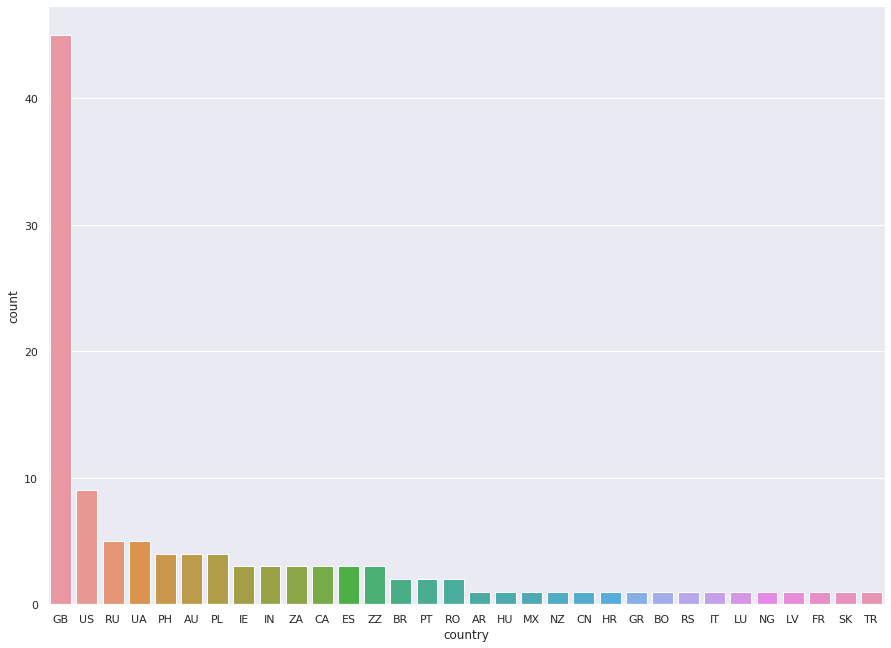

In [6]:
f, g = plt.subplots(figsize=(15, 11))
sns.countplot(x='country', data=df, order=df['country'].value_counts().index)


In [7]:
second_step = 'step_2.json'
df.to_json(second_step, orient='records')

# Step 2. Filtering by description

In [8]:
with open(second_step) as json_data:
    records = json.loads(json_data.read())
df = pd.DataFrame.from_records(records)

In [9]:
def filter_df(df, word, fields):
    mask_size = df.shape[0]
    mask = np.zeros(mask_size, dtype=bool)
    for field in fields:
        sub_mask = df[field].str.contains(word, flags=re.IGNORECASE)
        mask = mask | sub_mask
    return mask

In [10]:
description_fields = ['introduction', 'about_me', 'about_teacher',
                      'teaching_style']

In [11]:
mask1 = filter_df(df, "I've been teaching", description_fields)
mask2 = filter_df(df, 'I have been teaching', description_fields)
mask3 = filter_df(df, 'Homework', description_fields)
mask = (mask1 | mask2) & mask3

In [12]:
df = df[mask]

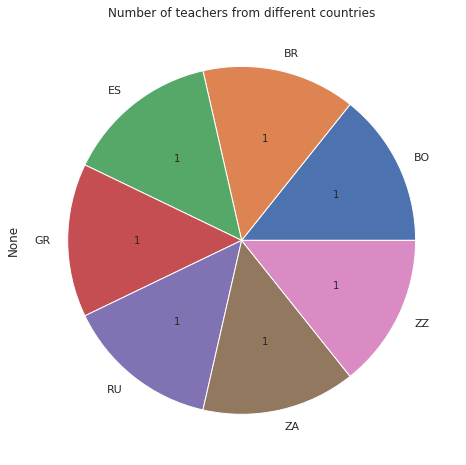

In [13]:
countries = df.groupby('country').size()
countries.plot(kind='pie', title='Number of teachers from different countries',
               figsize=[8, 8],
               autopct=lambda v: '{:.0f}'.format((v / 100) * countries.sum()))

In [14]:
third_step = 'step_3.json'
df.to_json(third_step, orient='records')

# Step 3. Working with reviews

In [15]:
with open(third_step) as json_data:
    records = json.loads(json_data.read())
df = pd.DataFrame.from_records(records)

In [16]:
df.head(10)

,about_me,about_teacher,country,finished_session,introduction,package,price_1h,pro_course_detail,teacher_id,teaching_style
0,My job is my passion! I like teaching language...,"I have been teaching Greek, English and French...",GR,1054,I am a professional online English and French ...,18.0,20.0,"[{'teacher_id': 1642736, 'language': 'english'...",1642736,I am trying to cover in an hour as much as I c...
1,Hello!\nMy name is Svetlana. I am from Russia....,My first teaching experience was long time ago...,RU,670,,17.0,18.0,"[{'teacher_id': 1810343, 'language': 'english'...",1810343,Every course starts with a small talk where I ...
2,I am a very curious and creative person. I lov...,"* I love talking about different topics, learn...",BR,935,"// PORTUGUÊS \nEu ensino inglês e português, a...",19.0,20.0,"[{'teacher_id': 2929765, 'language': 'english'...",2929765,English - EXCLUSIVE WEB PLATFORM / PLATAFORMA ...
3,I am a professional teacher with more than 10 ...,I have been teaching languages since my second...,ES,573,I have been teaching languages since my second...,15.3,17.0,"[{'teacher_id': 4773880, 'language': 'english'...",4773880,My style is really communicative and always ma...
4,I am a bilingual English teacher with a teachi...,I'd love to work with you if you:\n\n*** are a...,ZZ,246,,19.0,19.0,"[{'teacher_id': 5335629, 'language': 'english'...",5335629,When you learn English with me:\n\n✓ you SPEAK...
5,"Hi, I am a native speaker from South Africa. I...",I tend to structure my sessions according to m...,ZA,7706,About me:\nI am an experienced English teacher...,14.0,16.0,"[{'teacher_id': 1169629, 'language': 'english'...",1169629,*Informal Tutoring:\nConversation practice (he...
6,"✔ Speak Spanish with confidence, fluency, and ...","As a certified teacher for teaching, I have ex...",BO,2005,Thanks for to visit my profile. Spanish and En...,12.0,12.0,"[{'teacher_id': 1356176, 'language': 'english'...",1356176,I have many courses (Spanish/English) and two ...


In [17]:

lang = 'english'
def get_reviews(t_id):
    req = requests.get(f'url',
                       timeout=60)
    response = req.json()
    sleep(randint(1, 3))
    reviews = [(x['lesson_count'],
                x['user_info']['user_id'],
                x['comment_info']['content']) for x in response['data']
               if x['comment_info']['session_language'] == lang]
    user_set = set()
    cleared_reviews = []
    for (lesson_count, user_id, content) in reviews:
        if user_id in user_set or lesson_count==1:
            continue
        try:
            lng = detect(content)
        except Exception as e:
            lng = False
        if lng == 'en':
            cleared_reviews.append(
                ({'lesson_count': lesson_count, 'review': content}))
    return cleared_reviews

In [18]:
reviews = [get_reviews(teacher_id) for teacher_id in df.teacher_id]

In [19]:
df['reviews'] = reviews

## an average number of lessons

In [20]:
df['avg_lessons'] = 0.0
for i, row in df.iterrows():
    reviews = row['reviews']
    num_of_lessons = [x['lesson_count'] for x in reviews]
    df.at[i, 'avg_lessons'] = np.mean(num_of_lessons)

 

/home/user/devel/projects/flaty/parser/env/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/user/devel/projects/flaty/parser/env/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


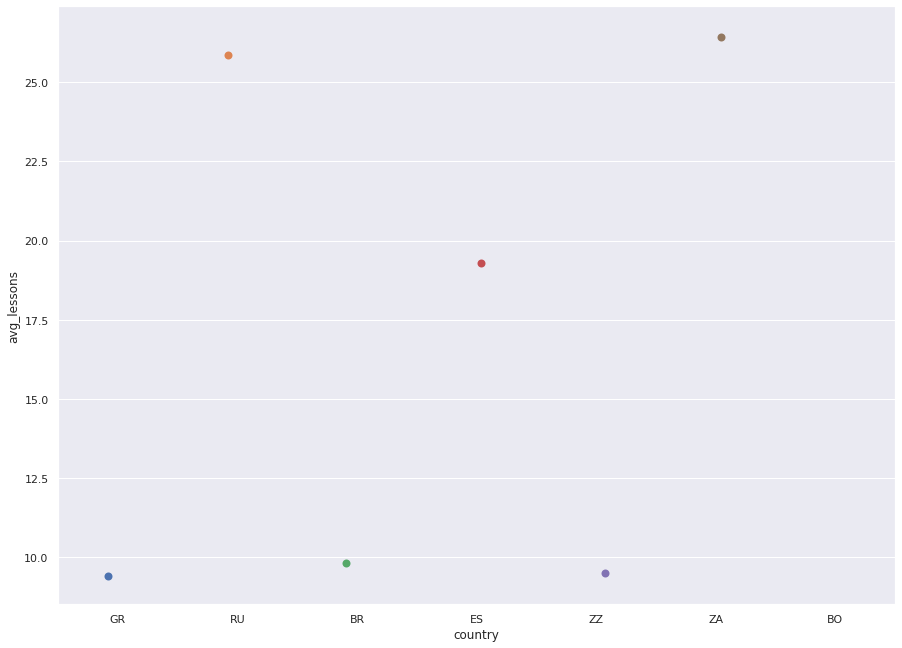

In [21]:
f, ax = plt.subplots(figsize=(15, 11))
sns.stripplot(y="avg_lessons", x="country",size=8, data=df)   

## Complex structures

In [22]:
stop_words = set(stopwords.words('english'))
have_no_meaning = ['thank', 'thanks', 'good', 'great', 'amazing', 'very']
stop_words.update(have_no_meaning)
def count_complexity_of_expresion(sentence):
    text = word_tokenize(sentence)
    tagged = pos_tag(text)

    tense = {'PastParticiple': 0, "Future/Conditional": 0}
    for word, tag in tagged:
        if tag == "VBN":
            tense["PastParticiple"] += 1
        elif tag == 'VBC':
            tense["Future/Conditional"] += 1           
    return tense

In [23]:


df['adapted_complexity_of_speech'] = 0.0
for i, row in df.iterrows():   
    reviews = row['reviews']
    complexity = []
    weights = []
    
    for about_review in reviews:
        review = about_review['review']
        lesson_count = about_review['lesson_count']
        complexity_of_expresion = count_complexity_of_expresion(review)
        complexity.append(sum(complexity_of_expresion.values()))
        
    complexity_index = np.mean(complexity)/row.finished_session
    df.at[i, 'adapted_complexity_of_speech'] = complexity_index 


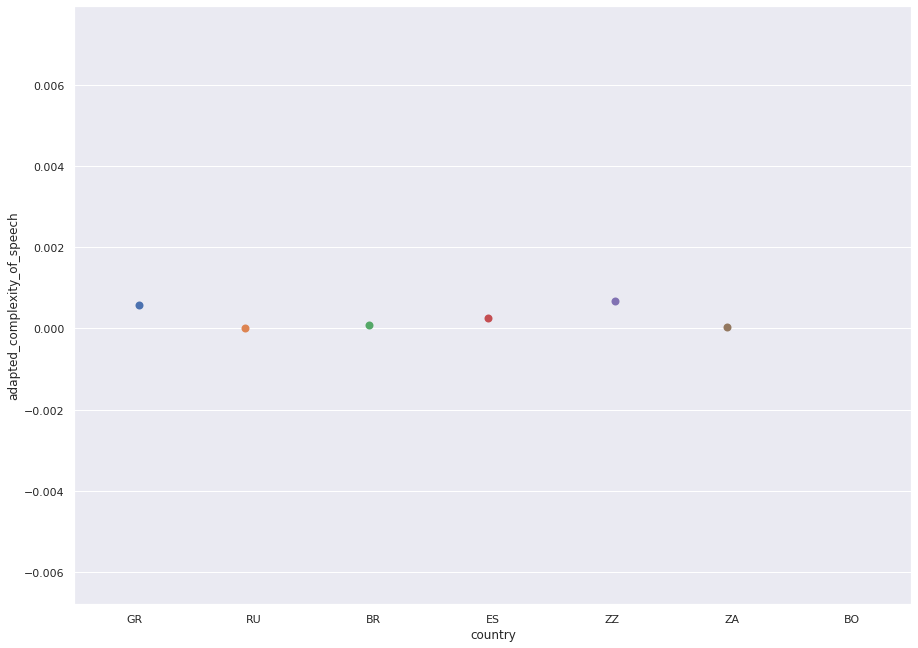

In [24]:

f, ax = plt.subplots(figsize=(15, 11))
sns.stripplot(y="adapted_complexity_of_speech", x="country",size=8, data=df)

## An automatic classification of English learner proficiency

In [25]:
model = load_model('model.h5')

In [26]:

with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [27]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) 
    text = BAD_SYMBOLS_RE.sub('', text) 
    text = ' '.join(word for word in text.split() if word not in stop_words) 
    return text

In [28]:

labels = ["A1","A2","B1","B2","C1","C2"]
MAX_SEQUENCE_LENGTH=250
def to_asses_level(text):
    original_text = text
    text = clean_text(text)
    text = word_tokenize(text)
    

    seq = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
    pred = model.predict(padded)
    
    CEFR_level =labels[np.argmax(pred)]
    return CEFR_level
    

In [29]:
a_part_of_my_latest_essay = '''It is a well-known fact that digital world is coming true.
                               A lot of things in our life, such as newspapers or magazines, 
                               have their digital analogues. 
                               Moreover the digital expansion could replace a basic column of society 
                               – libraries. I suppose it would be the greatest misleading –
                               to consider online as alternative.'''

In [30]:
to_asses_level(a_part_of_my_latest_essay)

'B2'

In [31]:
df['avg_assesed_level'] = 0.0
for i, row in df.iterrows():
    reviews = row['reviews']
    weights = []
    amount_of_words = []
    for idx,about_review in enumerate(reviews):
        lesson_count = about_review['lesson_count']
        review = about_review['review']
        assesed_level = to_asses_level(review)
        if assesed_level in ['A1','A2','B1']:
            score = 0
        elif assesed_level in ['B2']:
            score = 1
        elif assesed_level in ['C1','C2']:
            score = 2
            
        amount_of_words.append(score)
        weights.append(lesson_count)

    if weights and amount_of_words:
        expressiveness_of_review = np.average(amount_of_words, weights=weights)
        df.at[i, 'avg_assesed_level'] = expressiveness_of_review

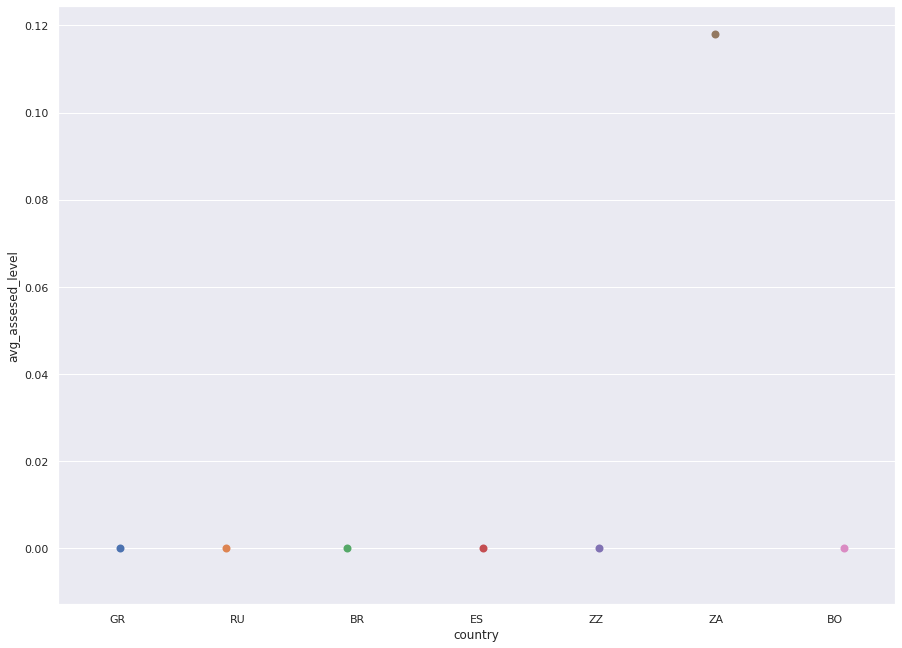

In [32]:

f, ax = plt.subplots(figsize=(15, 11))
sns.stripplot(y="avg_assesed_level", x="country", size=8,data=df)

In [33]:
forth_step = 'step_4.json'
df.to_json(forth_step, orient='records')

# Step4. Visualization+analysis

In [34]:
forth_step = 'step_4.json'
with open(forth_step) as json_data:
    records = json.loads(json_data.read())
df = pd.DataFrame.from_records(records)
df = df.fillna(0)

In [35]:
df['avg_lessons'] = df['avg_lessons'].rank()
df['adapted_complexity_of_speech'] = df['adapted_complexity_of_speech'].rank()
df['avg_assesed_level'] = df['avg_assesed_level'].rank()

In [36]:
df["score"] = df[['adapted_complexity_of_speech', 'avg_lessons','avg_assesed_level']].sum(axis=1)

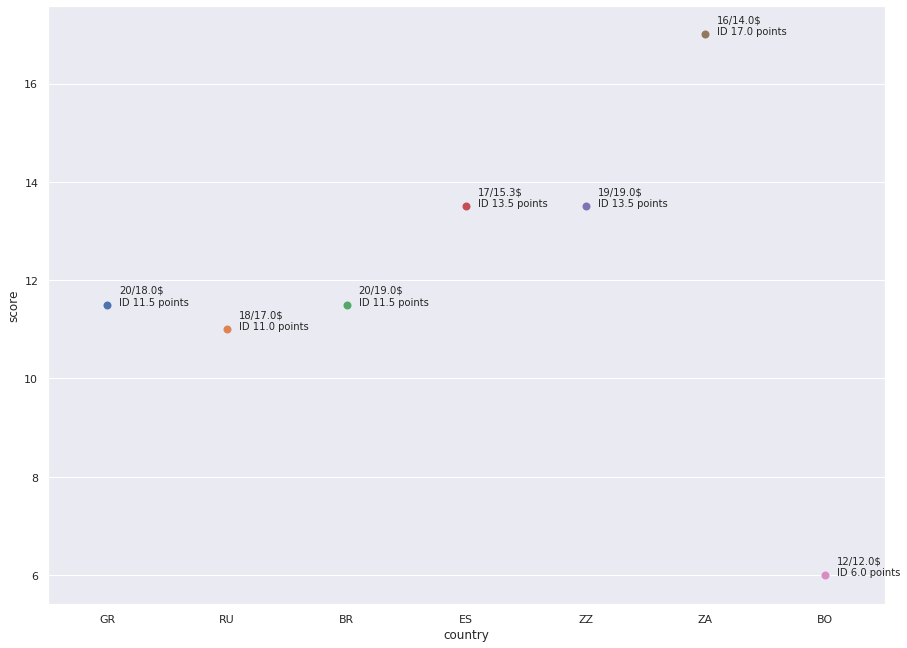

In [37]:

f, ax = plt.subplots(figsize=(15, 11))
ax = sns.swarmplot(y="score", x="country",size=8, data=df)
for i, row in df.iterrows():
    price = row.price_1h
    price_in_package = row.package
    ax.annotate(f'{int(price)}/{price_in_package}'+f'$\nID {row.score} points', (i + 0.1,row.score),size=10)